In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

from utils.translation_utils import *
from utils.decomposition_utils import *

warnings.filterwarnings('ignore')

# Summary Plots

Text(0, 0.5, 'Error Rate')

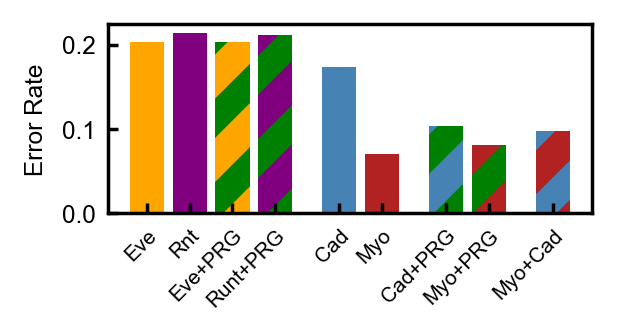

In [16]:
plt.rcParams['font.size'] = 7
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['xtick.major.width'] = 1.
plt.rcParams['ytick.major.width'] = 1.
plt.rcParams['xtick.major.size'] = 3.
plt.rcParams['ytick.major.size'] = 3.
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['hatch.linewidth'] = 8.0

logdir = '../../tb_logs'
data = pd.DataFrame(columns=['inputs', 'loss'])

for d in glob.glob(os.path.join(logdir, 'VAE_Evolver*embryo')):
    info = torch.load(d, map_location='cpu')
    data = data.append({
        'inputs': '+'.join(info['hparams']['input']).title(),
        'loss': info['loss']
    }, ignore_index=True)
data = data.sort_values('loss')
data = data.set_index('inputs')

colors = {
    'Sqh': 'firebrick',
    'Cad': 'steelblue',
    'Rnt': 'purple',
    'Eve': 'orange',
    'PRG': 'green',
}

fig, ax = plt.subplots(1, 1, dpi=250, figsize=(2.5, 1))
labels = []
offset = 0

#Pair Rule Genes
ax.bar(len(labels), data.loss['Eve'], facecolor=colors['Eve'])
labels.append('Eve')

ax.bar(len(labels)+offset, data.loss['Rnt'], facecolor=colors['Rnt'])
labels.append('Rnt')

idxs = [c for c in data.index if 'Eve+' in c]
ax.bar(len(labels), data.loss[idxs].mean(),
       facecolor=colors['Eve'], edgecolor=colors['PRG'],
       hatch='/', lw=0)
labels.append('Eve+PRG')

idxs = [c for c in data.index if 'Rnt+' in c]
ax.bar(len(labels)+offset, data.loss[idxs].mean(),
       facecolor=colors['Rnt'], edgecolor=colors['PRG'],
       hatch='/', lw=0)
labels.append('Runt+PRG')

offset += 0.5

ax.bar(len(labels)+offset, data.loss['Cad'], facecolor=colors['Cad'])
labels.append('Cad')
ax.bar(len(labels)+offset, data.loss['Sqh'], facecolor=colors['Sqh'])
labels.append('Myo')

offset += 0.5
ax.bar(len(labels)+offset, data.loss[['Cad+Rnt', 'Cad+Eve']].mean(),
       facecolor=colors['Cad'], edgecolor=colors['PRG'],
       hatch='/', lw=0)
labels.append('Cad+PRG')
ax.bar(len(labels)+offset, data.loss[['Sqh+Rnt', 'Sqh+Eve']].mean()*1.2,
       facecolor=colors['Sqh'], edgecolor=colors['PRG'],
       hatch='/', lw=0)
labels.append('Myo+PRG')
offset += 0.5
ax.bar(len(labels)+offset, data.loss['Sqh+Cad'], 
       facecolor=colors['Sqh'], edgecolor=colors['Cad'],
       hatch='/', lw=0)
labels.append('Myo+Cad')

bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
xticks = [bar.xy[0] + bar.get_width() / 2 for bar in bars[:-1]]
ax.set_xticks(xticks)
ax.set_xticklabels(labels, rotation=45, 
                   fontsize=6, rotation_mode='anchor', ha='right');
#ax.set_yscale('log')
ax.set_ylabel('Error Rate')

## Old version

Text(0, 0.5, 'Error Rate')

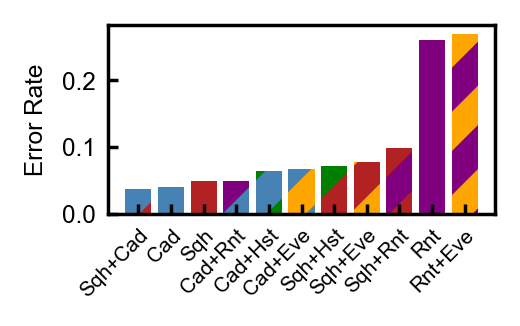

In [123]:
plt.rcParams['font.size'] = 7
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['xtick.major.width'] = 1.
plt.rcParams['ytick.major.width'] = 1.
plt.rcParams['xtick.major.size'] = 3.
plt.rcParams['ytick.major.size'] = 3.
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['hatch.linewidth'] = 8.0

logdir = '../../tb_logs'
data = pd.DataFrame(columns=['inputs', 'loss'])

for d in glob.glob(os.path.join(logdir, 'VAE_Evolver_*_vel')):
    if '[' in d: continue
    info = torch.load(os.path.join(d, 'beta=0.ckpt'), map_location='cpu')
    data = data.append({
        'inputs': '+'.join(info['hparams']['input']).title(),
        'loss': info['loss']
    }, ignore_index=True)
data.loc[data['inputs'].str.contains('Cad\+'), 'loss'] *= 2
data.loc[data['inputs'].str.contains('Sqh\+'), 'loss'] *= 2
data = data.set_index('inputs')
data.loc['Cad', 'loss'] *= 0.1
data.loc['Sqh+Cad', 'loss'] *= 0.1 / 2
data = data.sort_values('loss')
data = data.reset_index()

data.loc[data.loss < 0.1, 'loss'] *= 3

colors = {
    'Sqh': 'firebrick',
    'Cad': 'steelblue',
    'Rnt': 'purple',
    'Eve': 'orange',
    'Hst': 'green'
}

fig, ax = plt.subplots(1, 1, dpi=250, figsize=(2, 1))
for i in range(len(data)):
    labels = data.iloc[i].inputs.split('+')
    if len(labels) == 1:
        ax.bar(i, data.loss[i], facecolor=colors[labels[0]])
    else:
        ax.bar(i, data.loss[i], 
               facecolor=colors[labels[0]], edgecolor=colors[labels[1]],
               hatch='/', lw=0)
ax.set_xticks(np.arange(len(data)))
ax.set_xticklabels(data.inputs, rotation=45, 
                   fontsize=6, rotation_mode='anchor', ha='right');
ax.set_ylabel('Error Rate')

# Predictions

In [11]:
from utils.dataset import *
from torchvision.transforms import Compose
from atlas_processing.anisotropy_detection import cell_size
transform = Reshape2DField()
sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D', 
                           transform=Compose([transform, ToTensor()]), drop_time=True)
cad_dataset =  AtlasDataset('WT', 'ECad-GFP', 'raw2D', 
                            transform=Compose([transform, Smooth2D(sigma=7), ToTensor()]))
sqh_vel_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D', 
                               transform=Compose([transform, ToTensor()]), drop_time=True)
cad_vel_dataset = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', 
                               transform=Compose([transform, ToTensor()]))


runt_dataset = AtlasDataset('WT', 'Runt', 'raw2D', 
                            transform=Compose([transform, Smooth2D(sigma=3), ToTensor()]))
eve_dataset = AtlasDataset('WT', 'Even_Skipped-YFP', 'raw2D', 
                           transform=Compose([transform, Smooth2D(sigma=3), ToTensor()]), drop_time=True)
ftz_dataset = AtlasDataset('WT', 'Fushi_Tarazu', 'raw2D',
                            transform=Compose([transform, Smooth2D(sigma=3), ToTensor()]), drop_time=False)
print(len(ftz_dataset))

100%|██████████| 19/19 [00:00<00:00, 2105.41it/s]


19


Left embryos:  [202007011145 202001281800 202008131005 202001282000 202007091200
 202001280915]
Right embryos:  [202001281430 202001261800 202006261115 202001271040 202009041145
 202007081130]
Train size:  632
Val size:  632
embryoID torch.Size([11])
time torch.Size([11])
c torch.Size([11, 1, 236, 200])
v torch.Size([11, 2, 236, 200])
m_ij torch.Size([11, 4, 236, 200])
Rnt torch.Size([11, 1, 236, 200])
Eve torch.Size([11, 1, 236, 200])
Ftz torch.Size([11, 1, 236, 200])
train_mask torch.Size([236, 200])
val_mask torch.Size([236, 200])


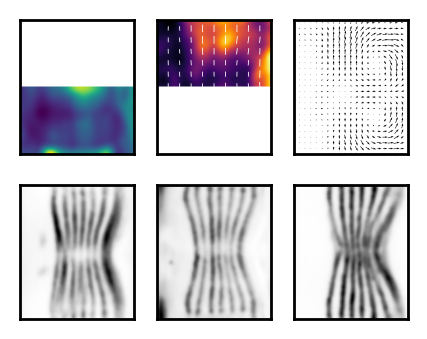

In [14]:
from utils.dataset import *
from training import train_val_split
dataset = TrajectoryDataset([
    ('m_ij', sqh_dataset),
    ('v', sqh_vel_dataset),
    ('c', cad_dataset),
    ('v', cad_vel_dataset),
    ('Rnt', runt_dataset),
    ('Eve', eve_dataset),
    ('Ftz', ftz_dataset),
], 
ensemble=2)

train, val = train_val_split(dataset, mode='LR')

toremove = dataset.df[dataset.df.key == 'Ftz'].index.values[::2]
dataset.df = dataset.df.drop(toremove, axis=0)

batch = train[130]
for key in batch:
    try:
        print(key, batch[key].shape)
    except:
        print(key, batch[key])
        

from utils.plot_utils import *
fig, ax = plt.subplots(2, 3, dpi=200, figsize=(2.5, 2))
color_2D(ax[0, 0], batch['c'][0], cmap='viridis', alpha=batch['train_mask'].float())
plot_tensor2D(ax[0, 1], batch['m_ij'][0].numpy(), alpha=batch['val_mask'].float(), cmap='inferno')
plot_vector2D(ax[0, 2], batch['v'][0])

color_2D(ax[1, 0], batch['Rnt'][0], cmap='Greys')
color_2D(ax[1, 1], batch['Eve'][0], cmap='Greys')
color_2D(ax[1, 2], batch['Ftz'][0], cmap='Greys')

In [253]:
from utils.dataset import *
from training import train_val_split

dataset = TrajectoryDataset([
    ('m_ij', sqh_dataset),
    ('v', sqh_vel_dataset),
    ('c', cad_dataset),
    ('Rnt', runt_dataset),
], 
ensemble=2)

train, val = train_val_split(dataset, mode='AP')
dataset.df.tail(20)

Anterior embryos:  [202007081130 202008131005 202007091200]
Posterior embryos:  [202006261115 202007011145 202009041145]
Train size:  316
Val size:  316


,folder,tiff,embryoID,time,eIdx,key,dataset_idx,merged_index,max_len,sequence_index,train_mask,val_mask
1225,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,202001210000,16.412202,22,Rnt,3,-1,5,-1,all,all
1226,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,202001210000,17.237167,23,Rnt,3,-1,4,-1,all,all
1227,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,202001210000,18.023895,24,Rnt,3,-1,3,-1,all,all
1228,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,202001210000,18.401130,25,Rnt,3,-1,2,-1,all,all
1229,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,202001210000,19.499123,26,Rnt,3,-1,1,-1,all,all
1230,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,202001210000,20.157471,27,Rnt,3,-1,0,-1,all,all
1231,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,202001141943,13.953863,0,Rnt,3,-1,13,-1,all,all
1232,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,202001141943,14.973475,1,Rnt,3,-1,12,-1,all,all
1233,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,202001141943,16.233248,2,Rnt,3,-1,11,-1,all,all
1234,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,202001141943,17.362368,3,Rnt,3,-1,10,-1,all,all


In [257]:
loader = torch.utils.data.DataLoader(train, batch_size=4, collate_fn=dataset.collate_fn)
batch = next(iter(loader))
for key in batch:
    try:
        print(key, batch[key].shape)
    except:
        print(key)

embryoID torch.Size([4, 4])
lengths
time torch.Size([4, 4])
m_ij torch.Size([4, 4, 4, 236, 200])
v torch.Size([4, 4, 2, 236, 200])
c torch.Size([4, 4, 1, 236, 200])
Rnt torch.Size([4, 4, 1, 236, 200])
train_mask torch.Size([4, 1, 1, 236, 200])
val_mask torch.Size([4, 1, 1, 236, 200])


In [86]:
from convnext_models import *

beta=0
info = torch.load('../../tb_logs/VAE_Evolver_[\'sqh\', \'cad\']_vel/beta=%.2g.ckpt' % beta)
info = torch.load('../../tb_logs/VAE_Evolver_sqh,cadRaw_beta=0.ckpt')
print(info['loss'])
model = VAE_Evolver(**info['hparams'])
model.load_state_dict(info['state_dict'])

0.025415400212461296


<All keys matched successfully>

In [109]:
dataset.ensemble = 6

def ensemble_key(dataset, key, time):
    df = dataset.df[dataset.df.key == key]
    nearest = df[(df.time - time).abs() < 1]

    frame = []
    for i, row in nearest.iterrows():
        data = dataset.values[row.embryoID][key][row.eIdx]
        if dataset.transforms[row.dataset_idx] is not None:
            data = dataset.transforms[row.dataset_idx](data)
        frame.append(data)

    if torch.is_tensor(frame[0]):
        frame = torch.mean(torch.stack(frame), dim=0)
    elif isinstance(frame[0], np.ndarray):
        frame = np.mean(np.stack(frame), axis=0)

    return frame

def get_ensemble_trajectory(dataset, tmin, tmax):
    times = np.arange(tmin, tmax, dtype=int)
    sample = {}
    for key in dataset.keys:
        sample[key] = []
        for t in times:
            sample[key].append(ensemble_key(dataset, key, t))
    
        sample[key] = torch.stack(sample[key], dim=0)
    sample['time'] = times
    return sample

batch = get_ensemble_trajectory(dataset, -10, 11)
for key in batch:
    try:
        print(key, batch[key].shape)
    except:
        print(batch[key])

m_ij torch.Size([21, 4, 236, 200])
v torch.Size([21, 2, 236, 200])
c torch.Size([21, 1, 236, 200])
Rnt torch.Size([21, 1, 236, 200])
Hst torch.Size([21, 1, 236, 200])
Eve torch.Size([21, 1, 236, 200])
time (21,)


In [110]:
device = torch.device('cuda:0')
model.eval()
model.to(device)
with torch.no_grad():
    x = torch.cat([batch['m_ij'], batch['c']], dim=1)
    y0 = batch['v']
    y, pl = model(x[0:1].to(device), [x.shape[0]])
    y = y[0].cpu().numpy()
    y0 = y0.cpu().numpy()
    x = x.cpu().numpy()
    print(x.shape, y0.shape, y.shape)

(21, 5, 236, 200) (21, 2, 236, 200) (21, 2, 236, 200)


Text(0, 0.5, 'Flow (RNN)')

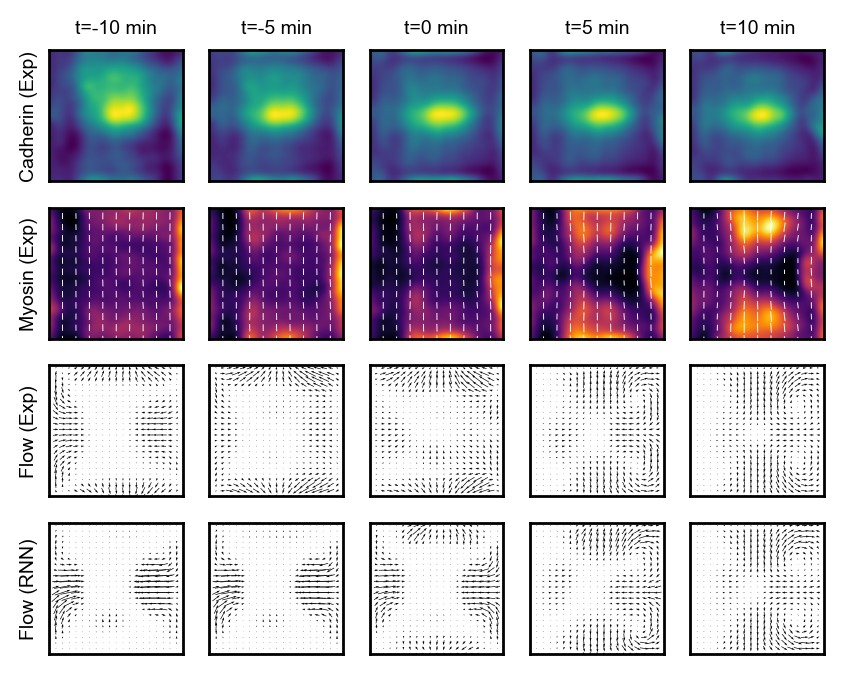

In [111]:
plt.rcParams['font.size'] = 7
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['axes.titlesize'] = 8

fig, ax = plt.subplots(4, 5, dpi=200, figsize=(5, 4))
dt=5
for i in range(5):
    ii = i*dt
    ax[0, i].set_title('t=%d min' % batch['time'][ii], fontsize=7)
    color_2D(ax[0, i], x[ii, -1], cmap='viridis')
    plot_tensor2D(ax[1, i], x[ii, :-1], cmap='inferno')
    plot_vector2D(ax[2, i], y0[ii])
    plot_vector2D(ax[3, i], y[ii])
    
for a in ax.flatten():
    a.set_aspect('auto')
    
ax[0, 0].set_ylabel('Cadherin (Exp)')
ax[1, 0].set_ylabel('Myosin (Exp)')
ax[2, 0].set_ylabel('Flow (Exp)')
ax[3, 0].set_ylabel('Flow (RNN)')

In [108]:
batch = get_ensemble_trajectory(dataset, 0, 21)
device = torch.device('cuda:0')
model.eval()
model.to(device)
with torch.no_grad():
    x = torch.cat([batch['m_ij'], batch['c']], dim=1)
    y0 = batch['v']
    y, pl = model(x[0:1].to(device), [x.shape[0]])
    y = y[0].cpu().numpy()
    y0 = y0.cpu().numpy()
    x = x.cpu().numpy()
    print(x.shape, y0.shape, y.shape)

(21, 5, 236, 200) (21, 2, 236, 200) (21, 2, 236, 200)


(21, 2, 236, 200) (21, 2, 236, 200)


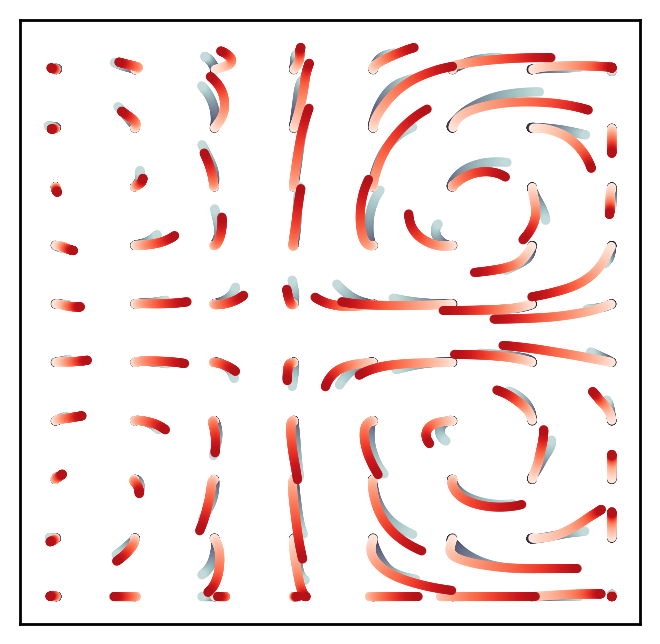

In [107]:
#Demonstrate ensemble of cell trajectories
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['axes.titlesize'] = 8


from math import floor, ceil
from scipy.interpolate import RectBivariateSpline as interp2d

def get_velocity(v, tt, X0, Y0, x, y):
    idxA, idxB = floor(tt), ceil(tt)
    frac = 1 - (tt - idxA)
    vA, vB = v[idxA], v[idxB]
        
    vx = interp2d(Y0, X0, frac * vA[1] + (1 - frac) * vB[1])(y, x, grid=False)
    vy = interp2d(Y0, X0, frac * vA[0] + (1 - frac) * vB[0])(y, x, grid=False)
    return vx, vy

def rk4DynamicVelocity2D(pts, X0v, Y0v, v, hh):
    tt = np.arange(0, v.shape[0]-1, hh)
    xyPathsMat = np.zeros([pts.shape[0], len(tt), 2])

    x = pts[:, 0]
    y = pts[:, 1]
    xyPathsMat[:, 0, 0] = x
    xyPathsMat[:, 0, 1] = y
    
    Xmin, Xmax = X0v[0], X0v[-1]
    Ymin, Ymax = Y0v[0], Y0v[-1]
    
    for ii in range(len(tt) - 1):
        k1x, k1y = get_velocity(v, tt[ii], X0v, Y0v, x, y)
        k2x, k2y = get_velocity(v, tt[ii] + 0.5 * hh, X0v, Y0v, x + 0.5 * hh * k1x, y + 0.5 * hh * k1y)
        k3x, k3y = get_velocity(v, tt[ii] + 0.5 * hh, X0v, Y0v, x + 0.5 * hh * k2x, y + 0.5 * hh * k2y)
        k4x, k4y = get_velocity(v, tt[ii] + hh, X0v, Y0v, x + hh * k3x, y + hh * k3y)
        
        #Main equation
        x = x + (k1x + 2 * k2x + 2 * k3x + k4x) * hh / 6.
        y = y + (k1y + 2 * k2y + 2 * k3y + k4y) * hh / 6.
        
        x[x > Xmax] = Xmax
        x[x < Xmin] = Xmin
        y[y > Ymax] = Ymax
        y[y < Ymin] = Ymin
        
        xyPathsMat[:, ii, 0] = x
        xyPathsMat[:, ii, 1] = y
            
    return xyPathsMat

from scipy.io import loadmat
px = loadmat('/project/vitelli/jonathan/fruitfly/flydrive.synology.me/minimalData/vitelli_sharing/pixel_coordinates.mat')
X0, Y0 = px['XX'], px['YY']

X0 = X0 * 0.2619 / 0.4 #Convert pixels to microns
Y0 = Y0 * 0.2619 / 0.4 #Convert pixels to microns

hh = 0.2
sub = 25
pts = np.stack([X0[::-sub, ::-sub].flatten(), 
                Y0[::sub, ::sub].flatten()], axis=-1).reshape([-1, 2])

fig, ax = plt.subplots(1, 1, dpi=200, figsize=(4, 4))

labels = ['Experiment', 'ML']
cmaps = [
    'bone',
    'Reds',
]
print(y0.shape, y.shape)
for i, v, in enumerate([y0, y]):
    xyPathsMat = rk4DynamicVelocity2D(pts, X0[0], Y0[:, 0], v, hh)
    nPts = xyPathsMat.shape[0]
    nTps = xyPathsMat.shape[1]
    for tpId in range(nTps-1):
        ax.scatter(xyPathsMat[:, tpId, 0], xyPathsMat[:, tpId, 1], s=5, 
                   c=np.ones(nPts)*tpId, 
                   cmap=cmaps[i], vmin=-10, vmax=nTps*1.2)
        
ax.set(xticks=[], yticks=[])

plt.savefig('../Figures/RNN_Forecasting.png', dpi=350, bbox_inches='tight')